# 02 - Danish Fungi - Localize Saliency Regions for all Images (DF20M)

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import data, training, models, metrics
from src.special import saliency
from src.utils import nb_setup, progress_log, visualization as viz

BBOX_DATA_DIR = '03_informed_augmentation/data_fungi/'
DATA_DIR = 'data/danish_fungi_dataset/'
TRAIN_SET_DIR = 'train_resized'

MODEL_ARCH = 'efficientnet_b0'
MODEL_NAME = 'baselines_mini/df2020_efficientnet_b0_ce_11-04-2021_19-52-55'

OUTPUT_FILE = 'DFM_bbox_annotations.csv'

nb_setup.init()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Load the Data

In [3]:
train_df = pd.read_csv(DATA_DIR + 'DF20M-train_metadata_PROD.csv')
valid_df = pd.read_csv(DATA_DIR + 'DF20M-public_test_metadata_PROD.csv')

classes = np.unique(train_df['scientificName'])
no_classes = len(classes)
assert no_classes == len(np.unique(valid_df['scientificName']))
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 182
Train set length: 32,753
Validation set length: 3,640


## Create Network and Dataset

In [4]:
# create model
model = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model, MODEL_NAME, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model.parameters()])

model_config = model.pretrained_config

In [5]:
# create transforms
_, valid_tfms = data.get_transforms(
    size=model_config['input_size'], mean=model_config['image_mean'],
    std=model_config['image_std'])

# create dataset
dataset = data.ImageDataset(
    pd.concat([train_df, valid_df], axis=0),
    img_path_col='image_path', label_col='scientificName',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms,
    labels=classes)

## Create Bounding Box Annotation for the Dataset

In [6]:
def find_bbox(model, img, label, device=None):
    # create saliency map
    saliency_map = saliency.get_saliency_map(model, img, label=label, device=device)

    # get bounding box covering highest intensities
    bbox, saliency_map_cleaned = saliency.get_bounding_box(
        saliency_map, bin_percentile=95, clust_pixel_th=10)
    _, h, w = img.shape
    bbox = data.BBox(*bbox).normalize(h, w)  # normalize bbox
    return bbox

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

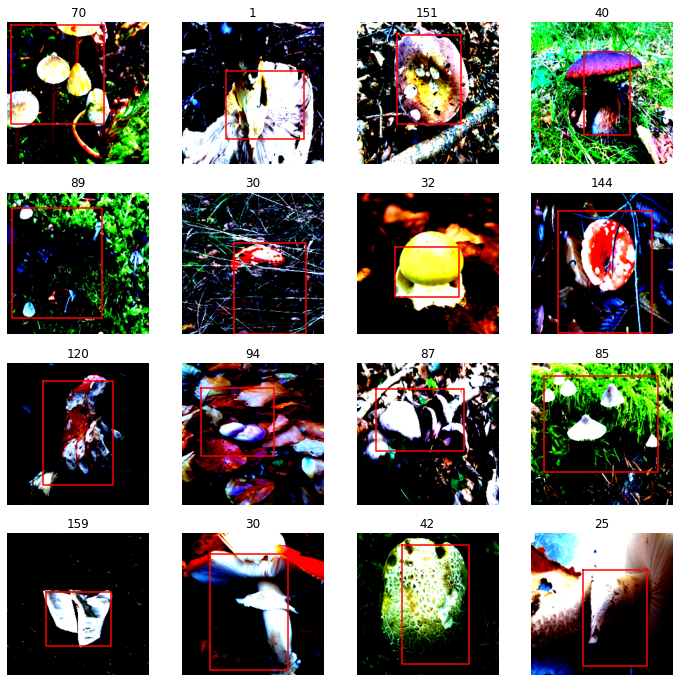

In [7]:
# visualize example
fig, axs = viz.create_fig(ncols=4, nrows=4, colsize=3, rowsize=3)
for i, ax in enumerate(axs):
    img, label = dataset[i]
    bbox = find_bbox(model, img, label, device=device)

    bbox = bbox.denormalize(224, 224)
    viz.imshow(img, bbox=bbox, title=f'{label}', ax=ax)

In [8]:
import os

# load already finished records
score_names = None
completed_ids = []
if os.path.isfile(BBOX_DATA_DIR + OUTPUT_FILE):
    df = pd.read_csv(BBOX_DATA_DIR + OUTPUT_FILE)
    score_names = list(df.columns)
    completed_ids = df['ImageUniqueID'].tolist()

In [9]:
dataset.df = dataset.df[~dataset.df['ImageUniqueID'].isin(completed_ids)]

In [10]:
from tqdm import tqdm

# create csv progress to save each step
csv_progress = progress_log.CSVProgress(
    filename=OUTPUT_FILE, path=BBOX_DATA_DIR)
csv_progress.score_names = score_names

# iterate images and find bboxes
for i, (img, label) in tqdm(enumerate(dataset), total=len(dataset)):
    record_id = dataset.df['ImageUniqueID'].iloc[i]
    if record_id not in completed_ids:
        bbox = find_bbox(model, img, label, device=device)
        xmin, ymin, xmax, ymax = bbox
        vals = {
            'ImageUniqueID': record_id,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax}
        csv_progress.log_epoch_scores(vals)

0it [00:00, ?it/s]
